In [1]:
import os
import numpy as np
import sklearn.linear_model as lm
import dask.delayed as delayed
from dask.distributed import Client, LocalCluster
import scipy.sparse as sparse
from glob import glob
import seaborn as sns
import pandas as pd
import dask
%matplotlib inline
folder = '../data/1kg_LD_blocks/'

In [2]:
import sys
sys.path.insert(0, os.path.abspath('../wepredict/'))

In [3]:
import pytorch_regression as pyreg

In [4]:
def sim(X):
    effect = np.random.normal(size=X.shape[1])
    index_causal = np.random.randint(0, len(effect), int(np.floor(len(effect)*0.8)))
    effect[index_causal] = 0
    y = X.dot(effect)
    return y

In [5]:
def reader_binary(file):  
    mat = sparse.load_npz(file)
    return mat.toarray()

In [6]:
def compute_lasso(X, y, index_valid, alphas):
    X_valid = X[index_valid,:]
    X = np.delete(X, index_valid, axis=0)
    y = np.delete(y, index_valid, axis=0)
    outcomes = []
    for alpha in alphas:
        model = lm.Lasso(alpha=alpha)
        model.fit(X, y)
        prediction = model.predict(X_valid)
        outcomes.append(prediction)
    return np.stack(outcomes).T

In [7]:
def get_training_valid_sample(X, y, index_valid):
    mask = np.ones(len(y), dtype=bool)
    mask[index_valid] = False
    return (X[mask,:], y[mask], X[~mask,:], y[~mask])

In [8]:
def compute_enet(X, y, X_valid, alphas, y_valid):
    model = lm.enet_path(X, y, alphas=alphas, X_copy=False)
    outcome = model[1].T.dot(X_valid.T).T
    measure = []
    for i in range(len(alphas)):
        measure.append(np.corrcoef(y_valid, outcome[:,i])[0,1])
    return {'prediction': outcome, 'model': model, 'accu': measure, 'pheno':y_valid}

In [9]:
def compute_pytorch_l1(X, y, X_valid, y_valid, alphas, mini_batch_size=200):
    mini_batch_size = 200
    model  = pyreg.pytorch_linear(X, y, X_valid, y_valid, True, type='c',
                                  mini_batch_size=mini_batch_size)
    accu, param, coef = model.run(penal='l1', epochs=501)
    return accu, param, coef

In [11]:
files = glob(folder+'/*')
files = np.random.choice(files, 10)

In [12]:
cluster = LocalCluster()
cluster.scale(4)
client = Client(cluster)

In [13]:
client

Client Scheduler: tcp://127.0.0.1:40645 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.31 GB


In [14]:
simu = []
for ff in files:
    mat = delayed(reader_binary)(ff)
    y = delayed(sim)(mat)
    simu.append(y)
sim_y = delayed(sum)(simu)
overview = delayed(pd.DataFrame.from_items)(zip([str(i) for i in range(len(files))], simu))

In [15]:
oo = overview.compute()
phenotype = oo.sum(axis=1).values

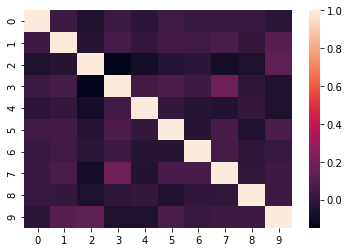

In [16]:
sns.heatmap(oo.corr())

In [17]:
mm = lm.LinearRegression()
mm.fit(oo.values, phenotype)
mm.coef_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
index_valid = np.random.choice(range(1092), 250, replace=False)
alphas = np.arange(0.2, 2, 0.2)
outcome = []
for ff in files:
    mat = delayed(reader_binary)(ff)
    sample = delayed(get_training_valid_sample)(mat, phenotype, index_valid)
    pred = delayed(compute_enet)(sample[0], sample[1], sample[2], alphas, sample[3])
    outcome.append(pred)

In [15]:
tt = dask.compute(outcome)

In [16]:
for i in range(10):
    test = tt[0][i][0]
    print(np.corrcoef(tt[0][i][3], test[:,0])[0, 1], tt[0][i][2][0])

0.43185581460298145 0.43185581460298145
0.4280346650316779 0.4280346650316779
0.3543199604776258 0.3543199604776258
0.4176738960353858 0.4176738960353858
0.33277053124867617 0.33277053124867617
0.4042018389375283 0.4042018389375283
0.5012526772558482 0.5012526772558482
0.4339908627234386 0.4339908627234386
0.3073181492207638 0.3073181492207638
0.37949126292099017 0.37949126292099017


In [17]:
for i in range(len(alphas)):
    print(np.corrcoef(sum([k[0] for k in tt[0]])[:,i], tt[0][0][0][:,0])[0,1])

0.8122316433445611
0.810707233226977
0.8087738642895911
0.8063156734227126
0.8024989728144802
0.7959731844910454
0.7874363043317035
0.772470248914293
0.7433427006933041


In [26]:
mask = np.ones(len(phenotype), dtype=bool)
mask[index_valid] = False
ppheno = tt[0][0][3]
ppheno == phenotype[~mask]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

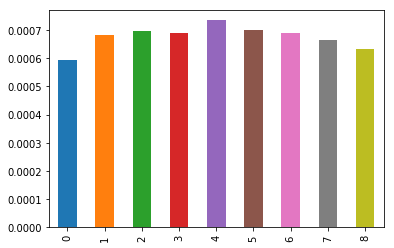

In [17]:
alpha_prediction = pd.DataFrame(y_mat)
alpha_prediction['pheno'] = phenotype[index_valid]
pred_corr = alpha_prediction.corr()['pheno']**2
pred_corr.drop('pheno', inplace=True)
pred_corr.plot(kind='bar')

In [88]:
block_id = 0
block_pred = outcome[block_id].compute()

/home/robert/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


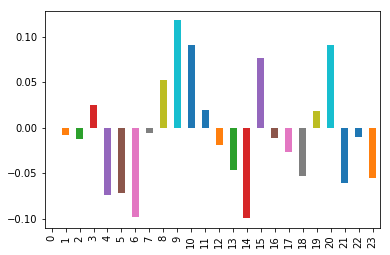

In [124]:
oo_new = oo.iloc[index_valid,:]
oo_new['block1'] = block_pred[:,0]
oo_new.corr()['block1'].drop('block1').plot(kind='bar')

In [117]:
block_pheno = oo.iloc[:,block_id].values[index_valid]
print(block_pheno.shape)
print(block_pred.shape)

(250,)
(250, 9)


In [71]:
alpha_value = 0
block_prediction = []
for i in range(len(files)):
    block_prediction.append(outcome[i].compute()[:,alpha_value])
block_frame = pd.DataFrame.from_items(zip([str(i) for i in range(len(files))], block_prediction))

AttributeError: 'numpy.ndarray' object has no attribute 'compute'

In [ ]:
sns.heatmap(block_frame.corr())

In [10]:
import pytorch_regression as pyreg
testfile = '../data/1kg_LD_blocks/22_LD_block_0.npz'
index_valid_test = np.random.randint(0, 1092, 100)
alphas = np.arange(0.01, 0.2, 0.02)
X = reader_binary(testfile)
y = sim(X)
sample = get_training_valid_sample(X, y, index_valid_test)
model_output = compute_pytorch_l1(sample[0], sample[1], sample[2], sample[3], (1-alphas), mini_batch_size=100)

(1001, 10063) (1001, 1)


/home/robert/software/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


epoch 99, loss 353.17279052734375, norm 82.205810546875
epoch 199, loss 351.782470703125, norm 79.45046997070312
epoch 299, loss 359.2929382324219, norm 77.28101348876953
epoch 399, loss 365.0677795410156, norm 75.74202728271484
epoch 499, loss 355.3102722167969, norm 76.94667053222656


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [69]:
outcome = model_output[0]
for i in range(len(alphas)):
        print(np.corrcoef(sample[3], outcome[:,i])[0,1])

0.7046058344709261
0.7024988554224044
0.7032510192627324
0.7042322623644179
0.705171350553417
0.7060537080367
0.706822976917417
0.7076749504992328
0.7084862175772175
0.7093529944341059
